# "Interpretable and tractable models of transcriptional noise for the rational design of single-molecule quantification experiments"
## by Gennady Gorin<sup>*</sup>, John Vastola<sup>*</sup>, Meichen Fang, and Lior Pachter
### <sup>*</sup> These authors contributed equally to this work.
# Companion notebook for Figure 2

This notebook is self-contained, and generates plots used in panel b. of Figure 2.

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
# Scientific computing imports
import numpy as np
from scipy.fft import irfft, irfftn
from scipy.stats import norm
from scipy.stats import nbinom, poisson
from scipy.stats import gamma as gammadist
import scipy.io as sio
from math import log, exp, sqrt, ceil

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

Store output in the "results" folder.

In [ ]:
!mkdir results

--------------------------

Necessary functions for (i) computing transcription rate trajectories and model likelihoods, and (ii) plotting.

In [ ]:
# @title Utility functions


# Utility function that converts between (x, y) qualitative regime coordinates to original parameters.
def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return beta, gamma, a, kappa, theta



# Get vector points on complex unit circle (argument of generating function)
def get_gf_arg(mx):
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    return g, half



# Sample from flattened 2D probability distribution p. 
# mx = [mx0, mx1] is the shape of the 2D domain we're sampling.
def sample_from_p(mx, num_data_points, p_flat):
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector

    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


In [ ]:
# @title Transcription rate simulation code

# Simulate the GOU transcription rate model.
def simulate_GOU_transcription(K0, t0, tf, dt, params, random_seed = None):
    beta, gamma, a, kappa, theta = params
    
    N=int(ceil((tf-t0)/dt))
    T=np.arange(t0, tf+dt, dt)
    
    K = np.zeros(len(T))
    K[0] = K0
    
    epsilon = 1e-6       # to prevent singularities in gamma distribution call when n = 0

    if isinstance(random_seed, int):
        np.random.seed(random_seed)
    
    # Directly simulate GOU via Euler-Maruyama time steps
    for i in range(len(K) - 1):
        n = poisson.rvs(mu=a*dt) + epsilon
        r = gammadist.rvs(a=n, scale=theta)
        
        K[i+1] = K[i] - kappa*dt*K[i] + r
    return K, T



# Simulate the CIR transcription rate model
def simulate_CIR_transcription(K0, t0, tf, dt, params, random_seed = None):
    
    # initial array and unfold parameters of CIR process
    N=int(ceil((tf-t0)/dt))
    T=np.arange(t0, tf+dt, dt)
    K=np.zeros(N+1)
    K[0]=K0
    beta, gamma, a, kappa, theta = params
  
    # precompute parameters
    exph = exp(-kappa*dt)
    K_avg = (a*theta)/kappa
    sigma_2 = 2*kappa*theta

    l_ = 4*kappa*exph / (sigma_2 * (1-exph)) #non-centrality patameter
    d = 4*K_avg*kappa/sigma_2 #degree of freedom
    c = sigma_2*(1-exph)/(4*kappa)

    # generate random variables
    if isinstance(random_seed, int):
        np.random.seed(random_seed)
    Z = np.random.normal(loc=0,scale=1, size=[N,2])
    log_U = np.log(np.random.uniform(low=0.0, high=1.0, size=N))
    chi = np.random.gamma(shape=d/2, scale=2, size=N)

    for i in range(N):
        s = l_ * K[i] + 2*log_U[i]
        if s <= 0:
            Y = 0
        else:
            Y = (Z[i,0] + sqrt(s))**2 + Z[i,1]**2
        K[i+1] = c * (chi[i] + Y)

    return K, T



In [ ]:
# @title GOU and CIR likelihood function code (not used; only for reference)

# Get 2 species GOU generating function using ODE method
def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters

    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))

    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))

    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1


    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf



# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    g, half = get_gf_arg(mx)

    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))

    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


  
## ======================================================


# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result



# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  

    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new



# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters

    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))

    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE

    # Solve ODE using RK4 method 
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)

    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf



# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    g, half = get_gf_arg(mx)

    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))

    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

In [ ]:
# @title Limiting likelihood function code



# Constitutive model likelihood (just a Poisson distribution)
def get_const_2sp(mx, params):
    beta, gamma, a, kappa, theta = params
    K_avg = (a*theta)/kappa
    mu_N, mu_M = K_avg/beta, K_avg/gamma


    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')     # 2D grid of points 

    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)



# Mixture / slow mean-reversion model likelihood (Poisson-gamma mixture)
def get_slowrev_2sp(mx, params):
    beta, gamma, a, kappa, theta = params
    alpha = a/kappa

    # Get generating function argument
    g, half = get_gf_arg(mx)

    # Get generating function
    log_gf = - alpha*np.log(1 - theta*(g[0]/beta + g[1]/gamma))
    gf = np.exp(log_gf)
    gf = gf.reshape(tuple(half))

    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss
    


# High gain GOU model likelihood (geometric bursts)
def get_highgain_GOU_2sp(mx, params):
    beta, gamma, a, kappa, theta = params
    b = theta/kappa

    # Get generating function argument
    g, half = get_gf_arg(mx)

    # Get generating function
    min_fudge, max_fudge = 0.01, 20                                     # Determine integration time scale / length
    dt = np.min([1/beta, 1/gamma])*min_fudge
    t_max = np.max([1/beta, 1/gamma])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))

    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))

    g0 = g[0].reshape((g[0].shape[0],1))
    g1 = g[1].reshape((g[1].shape[0],1))

    q0 = (g0 - (beta/(beta-gamma)*g1))*np.exp(-beta*t_array)
    q1 = (beta/(beta-gamma))*g1*np.exp(-gamma*t_array)
    q = b*(q0 + q1)


    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function



    gf = gf.reshape(tuple(half))

    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss



# High gain CIR model likelihood (more complicated than the others; not a well-characterized parametric family)
def get_highgain_CIR_2sp(mx, params):
    beta, gamma, a, kappa, theta = params
    b = theta/kappa

    # Get generating function argument
    g, half = get_gf_arg(mx)

    # Get generating function
    min_fudge, max_fudge = 0.01, 20                                     # Determine integration time scale / length
    dt = np.min([1/beta, 1/gamma])*min_fudge
    t_max = np.max([1/beta, 1/gamma])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))

    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))

    g0 = g[0].reshape((g[0].shape[0],1))
    g1 = g[1].reshape((g[1].shape[0],1))

    q0 = (g0 - (beta/(beta-gamma)*g1))*np.exp(-beta*t_array)
    q1 = (beta/(beta-gamma))*g1*np.exp(-gamma*t_array)
    q = b*(q0 + q1)


    integrand = 1 - np.sqrt(1 - 4*q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( (a/2)*integral)               # get generating function



    gf = gf.reshape(tuple(half))

    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

In [228]:
# @title Plotting code


# Plot scatter plot of data sampled from a given Pss
def plot_sampled_data_2D(mx, Pss, num_data_points=1000, limit=50, color="orange", name="sampled_data", random_seed = None):

    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    # Sample data
    d_N, d_M = sample_from_p(mx, num_data_points, Pss.flatten())
    data = [d_N, d_M]


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(d_N, d_M, alpha=0.1, color=color)

    ax.set_xlim(0, limit[0])
    ax.set_ylim(0, limit[1])
    ax.set_xlabel('# nascent', fontsize=35)
    ax.set_ylabel('# mature', fontsize=35)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig('results/'+name+'.png', bbox_inches='tight')
    plt.savefig('results/'+name+'.pdf', bbox_inches='tight')
    plt.show()

    return


# Plot transcription rate vs time for some model
def plot_transcription_rate(T, K, max_K, start, end, color, name):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(len(K)):
        color_ = color[i%len(color)]
        K_ = K[i]
        plt.plot(T[start:end], K_[start:end], color=color_, linewidth=2)
    plt.ylim(bottom=0)
    if max_K:
        plt.ylim(0,max_K)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('time (hours)', fontsize=35)
    ax.set_ylabel('K (hours$^{-1}$)', fontsize=35)

    plt.savefig('results/'+name+'.png', bbox_inches='tight')
    plt.savefig('results/'+name+'.pdf', bbox_inches='tight')
    plt.show()

    return


# Construct cartoon of cell transcription rates at one time point
def show_cell_cartoon(K, K_avg, name, name_add):

    K_frac = 1 - np.exp(- K/(5*K_avg))   # converts transcription rate to a color



    fig, ax = plt.subplots(figsize=(12,12))

    # Magic numbers
    num_cells = 8
    board_width, board_height = 1.68, 1.2
    edge_color = np.array([0,104,56])/255
    face_color = np.ones((num_cells, 3))
    ell_width, ell_height = 0.326, 0.446
    linewidth=8
    xy_list = [[0.184, 0.485],
    [0.584, 0.447],
    [0.599, 0.852],
    [0.935, 0.194],
    [1.031, 0.539],
    [0.966, 0.954],
    [1.474, 0.29],
    [1.381, 0.818]]
    angle_list = -np.array([0, 
    112.36, 18.34,
    87.35, 263.99, 163.9,
    324.96, 60])


    # Add cells to the figure
    min_color = np.array([1,1,215/255])
    max_color = edge_color

    cell_colors = [ K_frac[i]*max_color + (1 - K_frac[i])*min_color   for i in range(len(xy_list)) ]
  
    ells = [Ellipse(xy=xy_list[i],
                  width=ell_width, height=ell_height,
                  angle=angle_list[i], ec=edge_color, fc=cell_colors[i],lw=linewidth)
                                                         for i in range(len(xy_list))]
    for e in ells:
        ax.add_artist(e)


    # Set bounds and remove axes
    ax.set_xlim(0, board_width)
    ax.set_ylim(0, board_height)
    ax.axis('off')
    ax.set_aspect('equal')
    ax.invert_yaxis()


    # Save figure
    name_ = name + name_add
    plt.savefig("results/"+name_+".pdf", bbox_inches='tight')
    plt.savefig("results/"+name_+".png", bbox_inches='tight')
    plt.show()

    return


# Construct cartoons of cell transcription rates at multiple time points
def generate_cell_cartoons(num_examples, K_list, T, t1, t2, K_avg, name):

    # Get transcription rate at two designated times
    K_t1, K_t2 = [], []
    for i in range(num_examples):
        K_t1.append(K_list[i][t1])
        K_t2.append(K_list[i][t2])
        K_t1 = np.array(K_t1)
        K_t2 = np.array(K_t2)

    # First cartoon
    hrs = np.floor(T[t1])
    min = round((T[t1] - np.floor(T[t1]))*60, 2)
    print("At time ", hrs, " hours and", min, " minutes:")
    show_cell_cartoon(K_t1, K_avg, name, "_t1")

    # Second cartoon
    hrs = np.floor(T[t2])
    min = round((T[t2] - np.floor(T[t2]))*60, 2)
    print("At time ", hrs, " hours and", min, " minutes:")
    show_cell_cartoon(K_t2, K_avg, name, "_t2")
    return

-------------------------

## Set up parameter sets

In [ ]:
beta, gamma = 1, 1.2     # beta: splicing rate; gamma: mature degradation rate; units of 1/hours arbitrarily chosen
K_avg = 10               # average transcription rate for all parameter sets

limit_eps = 0.03   # controls proximity to limiting models (can't be zero due to singularity; smaller = longer simulation time)


# Low gain parameter set
x, y = limit_eps, limit_eps
params_lowgain = convert_xy_to_params(x, y, beta, gamma, K_avg)

# Fast reversion parameter set (not used)
x, y = 1 - limit_eps, limit_eps
params_fastrev = convert_xy_to_params(x, y, beta, gamma, K_avg)

# Slow reversion parameter set
x, y = limit_eps, 1 - limit_eps
params_slowrev = convert_xy_to_params(x, y, beta, gamma, K_avg)

# High gain parameter set
x, y = 1 - limit_eps, 1 - limit_eps
params_highgain = convert_xy_to_params(x, y, beta, gamma, K_avg)

-----------

## Transcription rate plots

dt:  0.0006593836588317852  hours

Low gain:


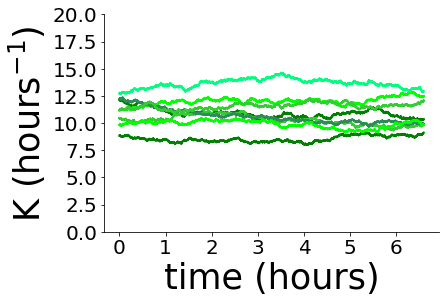

At time  2.0  hours and 38.25  minutes:


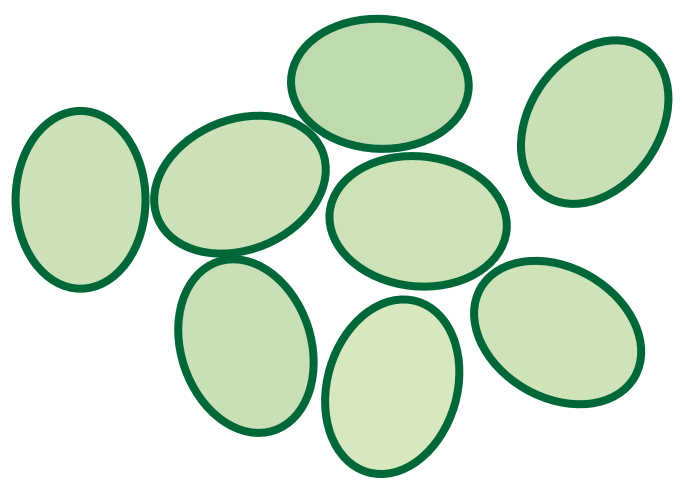

At time  2.0  hours and 58.03  minutes:


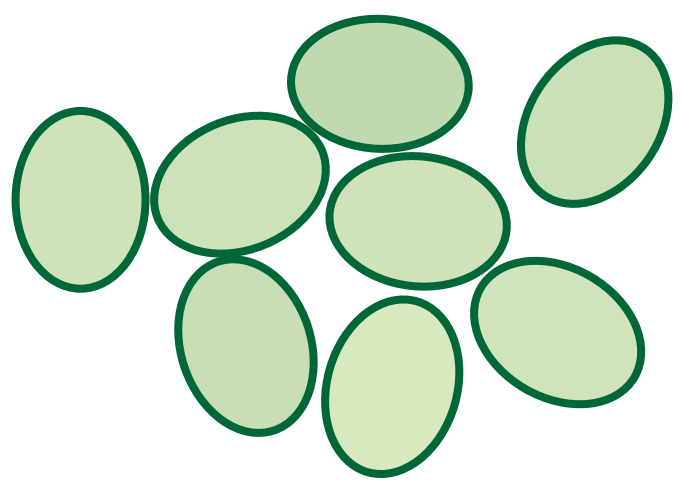

Slow reversion:


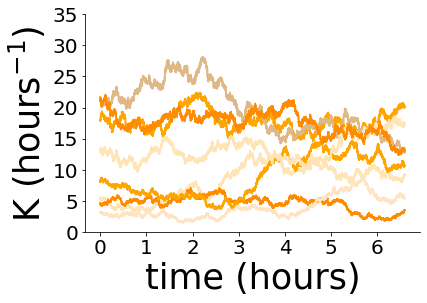

At time  2.0  hours and 38.25  minutes:


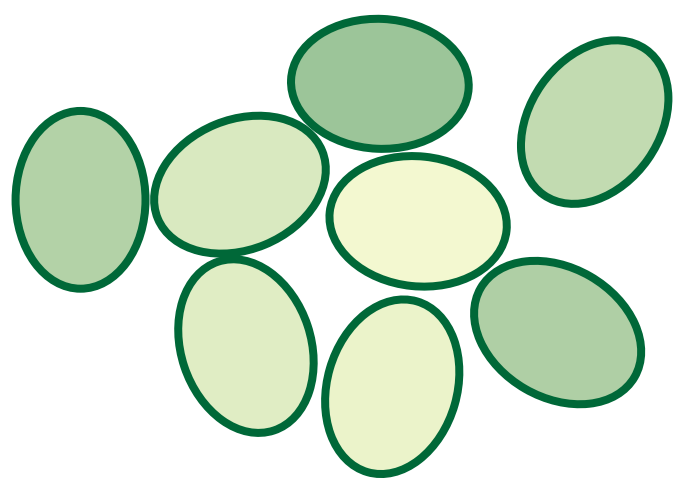

At time  2.0  hours and 58.03  minutes:


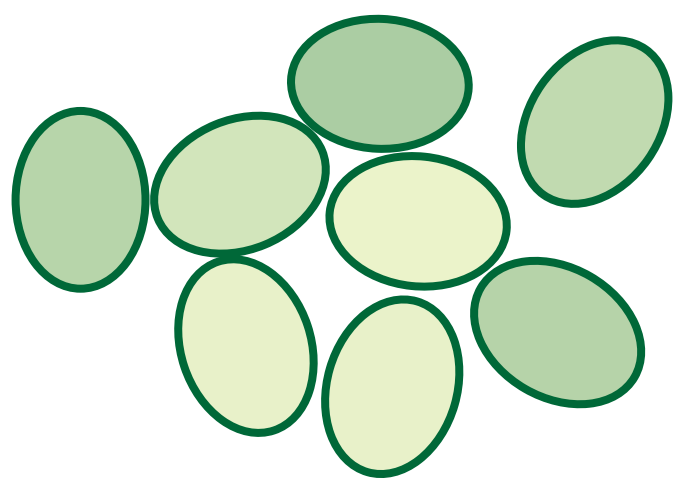

High gain CIR:


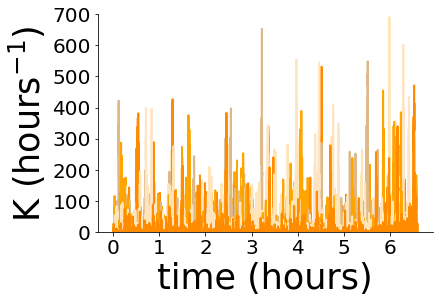

At time  2.0  hours and 38.25  minutes:


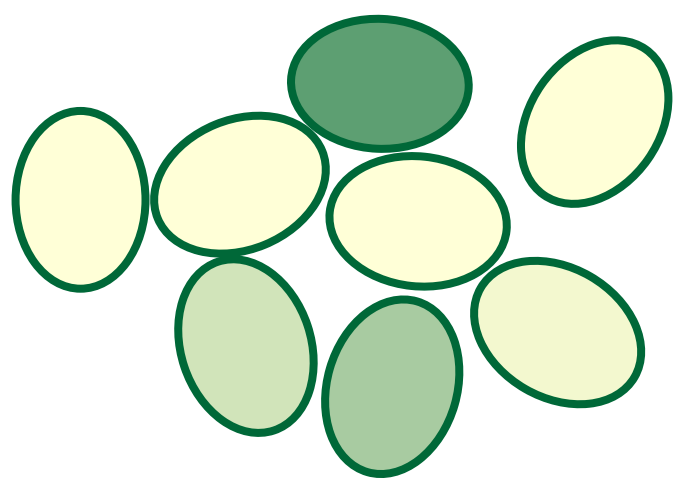

At time  2.0  hours and 58.03  minutes:


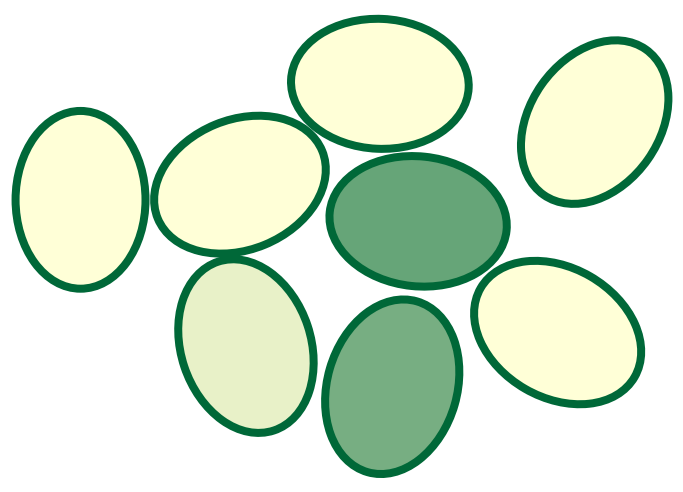

High gain GOU:


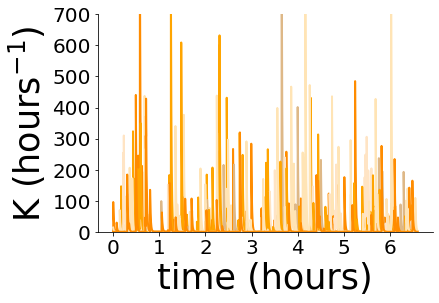

At time  2.0  hours and 38.25  minutes:


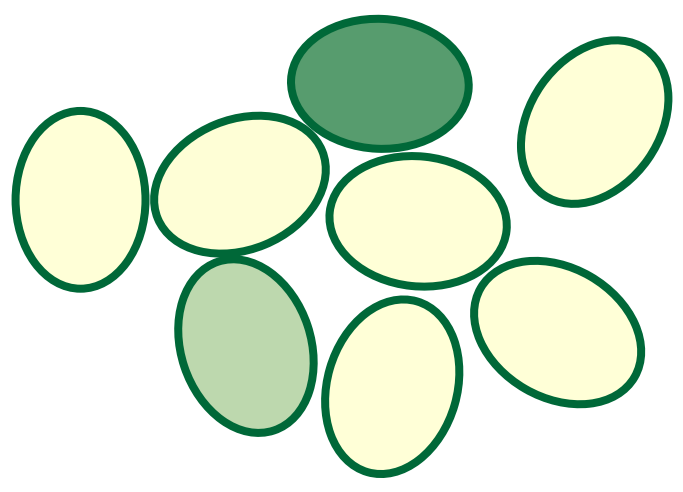

At time  2.0  hours and 58.03  minutes:


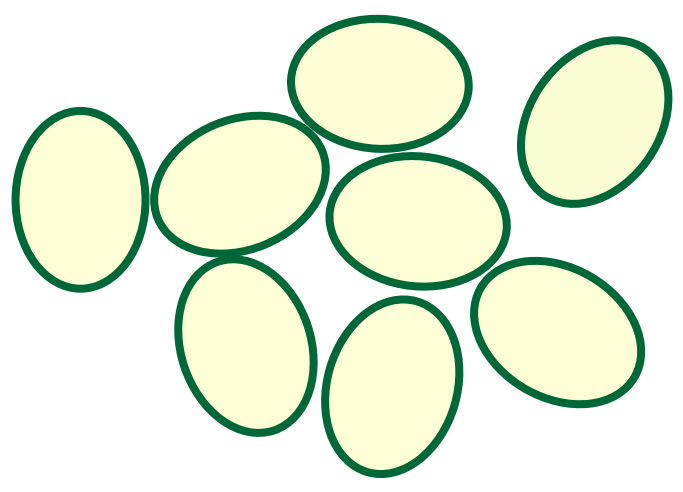

In [229]:
random_seed = 0
np.random.seed(random_seed)


t0, tf = 0, 7            # transcription rate simulation start and end time
start, end = 0,10000     # transcription rate trajectory plot start and end time (index)
t1, t2 = 4000, 4500    # times to visualize transcription rate with cell cartoons

max_rate = np.amax([params_lowgain, params_fastrev, params_highgain, params_slowrev])
dt = 0.1/max_rate        # simulation time step

max_K = 700              # manually chosen y axis upper bound for the high gain plots

poissonlike_colors = ['green', 'limegreen', 'lime', 'springgreen', 'seagreen']
overdispersed_colors = ['orange', 'moccasin', 'darkorange', 'burlywood', 'bisque']



num_examples = 8   # don't change this; needs to be at least 8 for the cell cartoon plotting to work properly

print("dt: ", dt, " hours")
print()

# ======================================


# Low gain parameter set
print("Low gain:")
beta, gamma, a, kappa, theta = params_lowgain
K0 = norm.rvs(loc=K_avg, scale=np.sqrt(K_avg*theta), size=num_examples)
K_CIR_list = []
for i in range(num_examples):
    K_CIR, T_CIR = simulate_CIR_transcription(K0[i], t0, tf, dt, params_lowgain)
    K_CIR_list.append(K_CIR)
plot_transcription_rate(T_CIR, K_CIR_list, 2*K_avg, start, end, poissonlike_colors, name="lowgain_trans_rate_sim")

generate_cell_cartoons(num_examples, K_CIR_list, T_CIR, t1, t2, K_avg, name="lowgain_cells")


# Slow reversion parameter set
print("Slow reversion:")
beta, gamma, a, kappa, theta = params_slowrev
alpha = K_avg/theta
K0 = gammadist.rvs(a=alpha, scale=theta,size=num_examples)
K_CIR_list = []
for i in range(num_examples):
    K_CIR, T_CIR = simulate_CIR_transcription(K0[i], t0, tf, dt, params_slowrev)
    K_CIR_list.append(K_CIR)
plot_transcription_rate(T_CIR, K_CIR_list, 3.5*K_avg, start, end, overdispersed_colors, name="slowrev_trans_rate_sim")

generate_cell_cartoons(num_examples, K_CIR_list, T_CIR, t1, t2, K_avg, name="slowrev_cells")



# High gain parameter set (CIR transcription rate)
print("High gain CIR:")
beta, gamma, a, kappa, theta = params_highgain
alpha = K_avg/theta
K0 = gammadist.rvs(a=alpha, scale=theta,size=num_examples)
#K0 = K_avg*np.ones(num_examples)
K_CIR_list = []
for i in range(num_examples):
    K_CIR, T_CIR = simulate_CIR_transcription(K0[i], t0, tf, dt, params_highgain)
    K_CIR_list.append(K_CIR)
plot_transcription_rate(T_CIR, K_CIR_list, max_K, start, end, overdispersed_colors, name="highgain_CIR_trans_rate_sim")

generate_cell_cartoons(num_examples, K_CIR_list, T_CIR, t1, t2, K_avg, name="highgain_CIR_cells")



# High gain parameter set (GOU transcription rate)
print("High gain GOU:")
beta, gamma, a, kappa, theta = params_highgain
alpha = K_avg/theta
K0 = gammadist.rvs(a=alpha, scale=theta,size=num_examples)
#K0 = K_avg*np.ones(num_examples)
K_GOU_list = []
for i in range(num_examples):
    K_GOU, T_GOU = simulate_GOU_transcription(K0[i], t0, tf, dt, params_highgain)
    K_GOU_list.append(K_GOU)
plot_transcription_rate(T_GOU, K_GOU_list, max_K, start, end, overdispersed_colors, name="highgain_GOU_trans_rate_sim")

generate_cell_cartoons(num_examples, K_GOU_list, T_GOU, t1, t2, K_avg, name="highgain_GOU_cells")

----------------

# Steady-state probability distribution plots

Low gain:


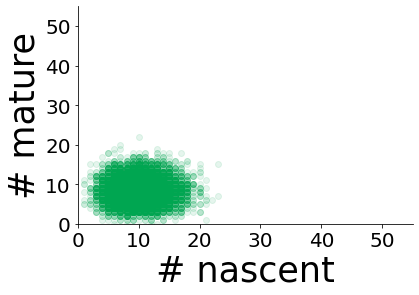


Slow reversion:


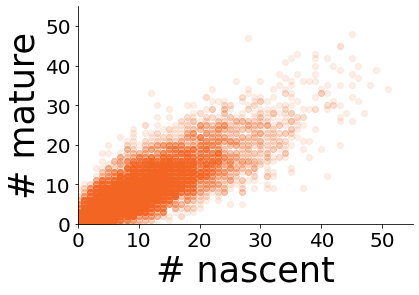


High gain GOU:


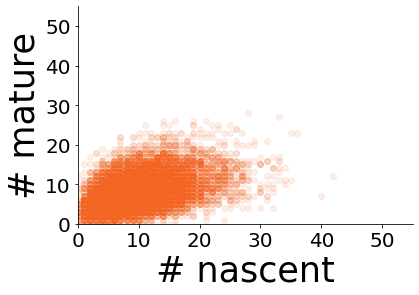


High gain CIR:


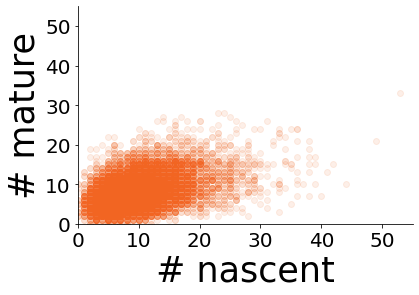

In [ ]:
random_seed = 1

mx = [150, 150]                                 # compute Pss on a grid of this size
num_data_points = 10000                         # number of data points to sample from each Pss

poissonlike_color = (0, 166/255, 81/255)        
overdispersed_color = (242/255,101/255,34/255)
limit = [55, 55]                                # limits of Pss plot x and y axes


print("Low gain:")
Pss_lowgain = get_const_2sp(mx, params_lowgain)
plot_sampled_data_2D(mx, Pss_lowgain, num_data_points=num_data_points, limit=limit,color=poissonlike_color, name="sampled_lowgain", random_seed=random_seed)
print()

print("Slow reversion:")
Pss_slowrev = get_slowrev_2sp(mx, params_slowrev)
plot_sampled_data_2D(mx, Pss_slowrev, num_data_points=num_data_points, limit=limit,color=overdispersed_color, name="sampled_slowrev", random_seed=random_seed)
print()

print("High gain GOU:")
Pss_highgain_GOU = get_highgain_GOU_2sp(mx, params_highgain)
plot_sampled_data_2D(mx, Pss_highgain_GOU, num_data_points=num_data_points, limit=limit,color=overdispersed_color, name="sampled_highgain_GOU", random_seed=random_seed)
print()

print("High gain CIR:")
Pss_highgain_CIR = get_highgain_CIR_2sp(mx, params_highgain)
plot_sampled_data_2D(mx, Pss_highgain_CIR, num_data_points=num_data_points, limit=limit,color=overdispersed_color, name="sampled_highgain_CIR", random_seed=random_seed)
print()


----------------

Download results.

In [225]:
!zip -r /content/file.zip /content/results
from google.colab import files
files.download("/content/file.zip")

  adding: content/results/ (stored 0%)
  adding: content/results/fastrev_trans_rate_sim.pdf (deflated 2%)
  adding: content/results/slowrev_cells_t1.pdf (deflated 13%)
  adding: content/results/highgain_GOU_cells_t1.pdf (deflated 13%)
  adding: content/results/lowgain_cells_t1.pdf (deflated 13%)
  adding: content/results/sampled_lowgain.pdf (deflated 9%)
  adding: content/results/lowgain_trans_rate_sim.png (deflated 4%)
  adding: content/results/lowgain_trans_rate_sim.pdf (deflated 1%)
  adding: content/results/highgain_GOU_trans_rate_sim.pdf (deflated 9%)
  adding: content/results/sampled_highgain_CIR.png (deflated 3%)
  adding: content/results/sampled_lowgain.png (deflated 4%)
  adding: content/results/sampled_slowrev.png (deflated 2%)
  adding: content/results/highgain_CIR_cells_t2.png (deflated 11%)
  adding: content/results/slowrev_cells_t2.png (deflated 11%)
  adding: content/results/slowrev_trans_rate_sim.pdf (deflated 1%)
  adding: content/results/highgain_GOU_trans_rate_sim.pn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>